In [ ]:
#BINARY CLASSIFICATION - 8PC

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("8 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Impute missing values (debugging approach propsed by Gemini AI)
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

df = df.copy()

# Update labels for binary classification
def encode_binary_class(row):
    if row['flare_class_encoded'] < 300:
        return 0  # B/C class
    else:
        return 1  # M/X class

# copy to avoid df fragmentation
df['binary_class'] = df.apply(encode_binary_class, axis=1)
df = df.copy()

print("Binary Class Distribution:")
print(df['binary_class'].value_counts())

def create_binary_splits(n_repeats=100):
    all_splits = []
    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each binary class
            bc_class_samples = resample(df[df['binary_class'] == 0], replace=False, n_samples=165, random_state=repeat)
            mx_class_samples = resample(df[df['binary_class'] == 1], replace=False, n_samples=165, random_state=repeat)
            complete_data = pd.concat([bc_class_samples, mx_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'binary_class']) # feature values
            y = complete_data['binary_class']  # Target value
            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue
    return all_splits

# Function to evaluate model with GridSearchCV
def evaluate_model_with_xgboost(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'learning_rate': [0.1, 0.9],
        'subsample': [0.01, 1]
    }

    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_xgb = grid_search.best_estimator_

        y_pred = best_model_xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

        test_pred_prob = best_model_xgb.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred_prob)
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, test_pred_prob)
        pr_auc = average_precision_score(y_test, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), np.mean(f1_scores), accuracy_scores, roc_auc_scores, pr_auc_scores, f1_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate binary classification with 10-fold cross-validation and GridSearchCV
binary_splits = create_binary_splits()
if len(binary_splits) == 0:
    print("No valid splits created.")
else:
    binary_results = [evaluate_model_with_xgboost(X, y) for X, y in binary_splits]
    mean_binary_accuracy = np.mean([result[0] for result in binary_results])
    mean_binary_roc_auc = np.mean([result[1] for result in binary_results])
    mean_binary_pr_auc_8PC = np.mean([result[2] for result in binary_results])
    mean_f1_score = np.mean([result[3] for result in binary_results])

    print(f"Mean Binary Accuracy: {mean_binary_accuracy}")
    print(f"Mean Binary ROC AUC: {mean_binary_roc_auc}")
    print(f"Mean Binary PR AUC: {mean_binary_pr_auc_8PC}")
    print(f"Mean Binary F1 Score: {mean_f1_score}")

    # Plot Mean ROC AUC Curve
    mean_fpr_8PC = np.linspace(0, 1, 100)
    tpr_interpolated = [np.interp(mean_fpr_8PC, fpr, tpr) for fpr, tpr in zip(binary_results[4][8], binary_results[4][9]) if isinstance(fpr, np.ndarray) and isinstance(tpr, np.ndarray)]
    mean_tpr_8PC = np.mean(tpr_interpolated, axis=0)
    mean_tpr_8PC[-1] = 1.0
    mean_roc_auc_8PC = auc(mean_fpr_8PC, mean_tpr_8PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='green', label=f'Mean ROC (8PC) (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Mean ROC AUC Curve', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

    # Plot Mean Precision-Recall Curve
    precision_interpolated_8PC = [np.interp(mean_fpr_8PC, np.linspace(0, 1, len(precision)), precision) for precision, _ in binary_results[4][10] if isinstance(precision, np.ndarray)]
    recall_interpolated_8PC = [np.interp(mean_fpr_8PC, np.linspace(0, 1, len(recall)), recall) for recall, _ in binary_results[4][11] if isinstance(recall, np.ndarray)]
    mean_precision_8PC = np.mean(precision_interpolated_8PC, axis=0)
    mean_recall_8PC = np.mean(recall_interpolated_8PC, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='green', label=f'Mean PR (8PC) (AUC = {mean_binary_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Mean Precision-Recall Curve', fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR_curve_XGB_BINARY.png")
    plt.show()

# Print final class distributions for debugging
if len(binary_splits) > 0:
    X, y = binary_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [ ]:
#BINARY CLASSIFICATION - 100PC

# Load your dataset
df = pd.read_csv("100 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Impute missing values (debugging approach propsed by Gemini AI)
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

df = df.copy()

# Update labels for binary classification
def encode_binary_class(row):
    if row['flare_class_encoded'] < 300:
        return 0  # B/C class
    else:
        return 1  # M/X class

# copy to avoid df fragmentation
df['binary_class'] = df.apply(encode_binary_class, axis=1)
df = df.copy()

print("Binary Class Distribution:")
print(df['binary_class'].value_counts())

def create_binary_splits(n_repeats=100):
    all_splits = []
    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each binary class
            bc_class_samples = resample(df[df['binary_class'] == 0], replace=False, n_samples=165, random_state=repeat)
            mx_class_samples = resample(df[df['binary_class'] == 1], replace=False, n_samples=165, random_state=repeat)
            complete_data = pd.concat([bc_class_samples, mx_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'binary_class']) # feature values
            y = complete_data['binary_class']  # Target value
            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue
    return all_splits

# Function to evaluate model with GridSearchCV
def evaluate_model_with_xgboost(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'learning_rate': [0.1, 0.9],
        'subsample': [0.01, 1]
    }

    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_xgb = grid_search.best_estimator_

        y_pred = best_model_xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

        test_pred_prob = best_model_xgb.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred_prob)
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, test_pred_prob)
        pr_auc = average_precision_score(y_test, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), np.mean(f1_scores), accuracy_scores, roc_auc_scores, pr_auc_scores, f1_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate binary classification with 10-fold cross-validation and GridSearchCV
binary_splits = create_binary_splits()
if len(binary_splits) == 0:
    print("No valid splits created.")
else:
    binary_results = [evaluate_model_with_xgboost(X, y) for X, y in binary_splits]
    mean_binary_accuracy = np.mean([result[0] for result in binary_results])
    mean_binary_roc_auc = np.mean([result[1] for result in binary_results])
    mean_binary_pr_auc_100PC = np.mean([result[2] for result in binary_results])
    mean_f1_score = np.mean([result[3] for result in binary_results])

    print(f"Mean Binary Accuracy: {mean_binary_accuracy}")
    print(f"Mean Binary ROC AUC: {mean_binary_roc_auc}")
    print(f"Mean Binary PR AUC: {mean_binary_pr_auc_100PC}")
    print(f"Mean Binary F1 Score: {mean_f1_score}")

     # combined Plot Mean ROC AUC Curve (8;100 PC)
    mean_fpr_100PC = np.linspace(0, 1, 100)
    tpr_interpolated = [np.interp(mean_fpr_100PC, fpr, tpr) for fpr, tpr in zip(binary_results[4][8], binary_results[4][9]) if isinstance(fpr, np.ndarray) and isinstance(tpr, np.ndarray)]
    mean_tpr_100PC = np.mean(tpr_interpolated, axis=0)
    mean_tpr_100PC[-1] = 1.0
    mean_roc_auc_100PC = auc(mean_fpr_100PC, mean_tpr_100PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='violet', label=f'Mean ROC (8PC) (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_100PC, mean_tpr_100PC, color='orange', label=f'Mean ROC (100PC) (AUC = {mean_roc_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Mean ROC AUC Curve', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

     # combined Plot Mean PR Curve (8;100 PC)
    precision_interpolated_100PC = [np.interp(mean_fpr_100PC, np.linspace(0, 1, len(precision)), precision) for precision, _ in binary_results[4][10] if isinstance(precision, np.ndarray)]
    recall_interpolated_100PC = [np.interp(mean_fpr_100PC, np.linspace(0, 1, len(recall)), recall) for recall, _ in binary_results[4][11] if isinstance(recall, np.ndarray)]
    mean_precision_100PC = np.mean(precision_interpolated_100PC, axis=0)
    mean_recall_100PC = np.mean(recall_interpolated_100PC, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='violet', label=f'Mean PR (8PC) (AUC = {mean_binary_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_100PC, mean_precision_100PC, color='orange', label=f'Mean PR (100PC) (AUC = {mean_binary_pr_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Mean Precision-Recall Curve', fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR_curve_XGB_BINARY.png")
    plt.show()

# Print final class distributions for debugging
if len(binary_splits) > 0:
    X, y = binary_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")


Original Class Distribution:
flare_class_encoded
200    7560
300    3440
400     440
Name: count, dtype: int64
Encoded Class Distribution:
encoded_class
0    7560
1    3440
2     440
Name: count, dtype: int64
Mean Multiclass Accuracy: 0.7167311827956989
Mean Multiclass ROC AUC: 0.8547203859992274
Mean Multiclass PR AUC: 0.7967659568514702
Mean Multiclass F1 Score: 0.7119533971282634


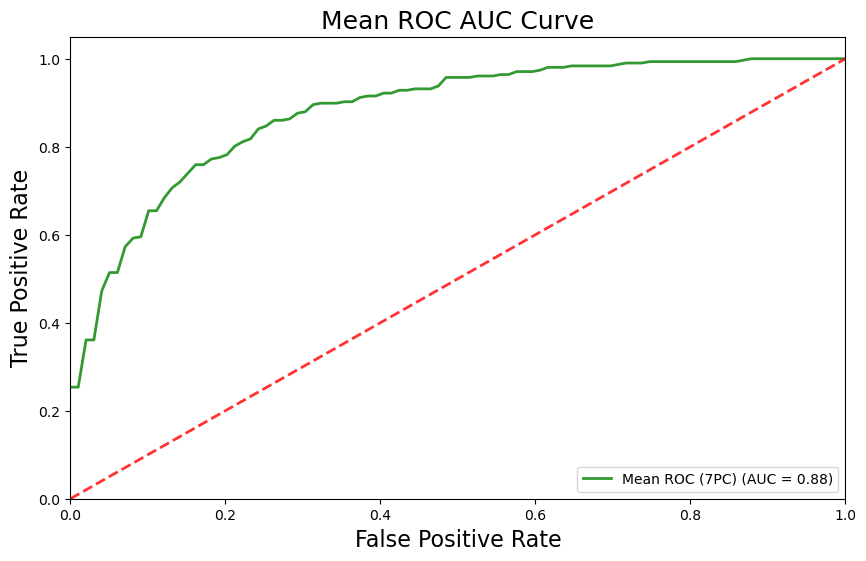

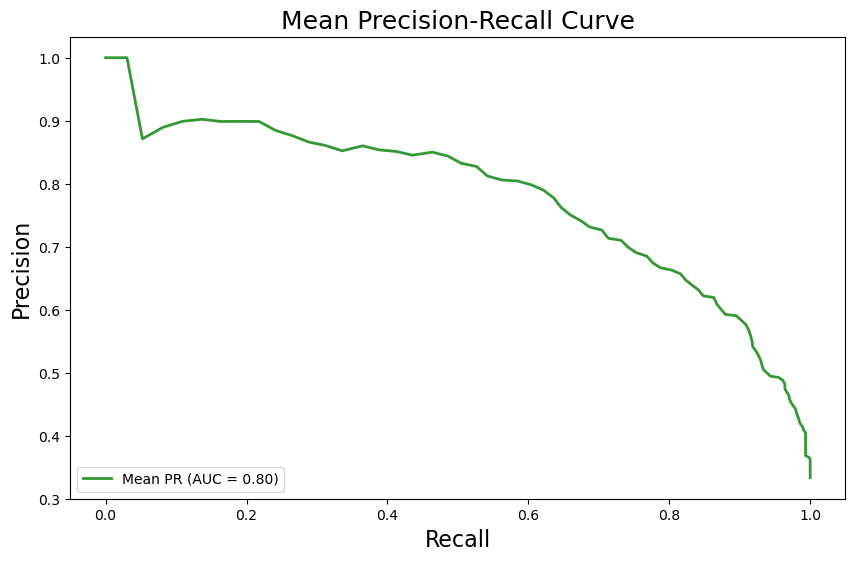

Final Training Set Class Distribution:
encoded_class
0    142
1    142
2     23
Name: count, dtype: int64


In [3]:
#MULTICLASS CLASSIFICATION - 7PC
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("7_pc.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Impute missing values (debugging approach propsed by Gemini AI)
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

# copy df to avoid defragmentation
df = df.copy()

# Encode class labels
label_encoder = LabelEncoder()
df['encoded_class'] = label_encoder.fit_transform(df['flare_class_encoded'])

print("Encoded Class Distribution:")
print(df['encoded_class'].value_counts())

def create_multiclass_splits(df, n_repeats=100):
    all_splits = []
    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            c_class_samples = resample(df[df['encoded_class'] == 0], replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['encoded_class'] == 1], replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['encoded_class'] == 2], replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'encoded_class'])
            y = complete_data['encoded_class']  # Encoded multiclass target

            if len(X) == len(y):  # Ensure consistent lengths
                all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue
    return all_splits

# Function to evaluate model with GridSearchCV
def evaluate_model_with_xgboost(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'learning_rate': [0.1, 0.9],
        'subsample': [0.01, 1]
    }

    model_xgb = XGBClassifier(eval_metric='logloss')
    grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_xgb = grid_search.best_estimator_

        y_pred = best_model_xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_xgb.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), np.mean(f1_scores), accuracy_scores, roc_auc_scores, pr_auc_scores, f1_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multiclass classification with 10-fold cross-validation and GridSearchCV
multiclass_splits = create_multiclass_splits(df)
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    multiclass_results = [evaluate_model_with_xgboost(X, y) for X, y in multiclass_splits]
    mean_multiclass_accuracy = np.mean([result[0] for result in multiclass_results])
    mean_multiclass_roc_auc = np.mean([result[1] for result in multiclass_results])
    mean_multiclass_pr_auc_7PC = np.mean([result[2] for result in multiclass_results])
    mean_f1_score = np.mean([result[3] for result in multiclass_results])

    print(f"Mean Multiclass Accuracy: {mean_multiclass_accuracy}")
    print(f"Mean Multiclass ROC AUC: {mean_multiclass_roc_auc}")
    print(f"Mean Multiclass PR AUC: {mean_multiclass_pr_auc_7PC}")
    print(f"Mean Multiclass F1 Score: {mean_f1_score}")

    #  Plot Mean ROC AUC Curve
    mean_fpr_7PC = np.linspace(0, 1, 100)
    tpr_interpolated_7PC = [np.interp(mean_fpr_7PC, fpr, tpr) for fpr, tpr in zip(multiclass_results[4][8], multiclass_results[4][9]) if isinstance(fpr, np.ndarray) and isinstance(tpr, np.ndarray)]
    mean_tpr_7PC = np.mean(tpr_interpolated_7PC, axis=0)
    mean_tpr_7PC[-1] = 1.0
    mean_roc_auc_7PC = auc(mean_fpr_7PC, mean_tpr_7PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_7PC, mean_tpr_7PC, color='green', label=f'Mean ROC (7PC) (AUC = {mean_roc_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Mean ROC AUC Curve', fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC_AUC_curve_XGB_MULTICLASS.png")
    plt.show()

    # Plot Mean Precision-Recall Curve
    precision_interpolated_7PC = [np.interp(mean_fpr_7PC, np.linspace(0, 1, len(precision)), precision) for precision in multiclass_results[4][10] if isinstance(precision, np.ndarray)]
    recall_interpolated_7PC = [np.interp(mean_fpr_7PC, np.linspace(0, 1, len(recall)), recall) for recall in multiclass_results[4][11] if isinstance(recall, np.ndarray)]
    mean_precision_7PC = np.mean(precision_interpolated_7PC, axis=0)
    mean_recall_7PC = np.mean(recall_interpolated_7PC, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_7PC, mean_precision_7PC, color='green', label=f'Mean PR (AUC = {mean_multiclass_pr_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Mean Precision-Recall Curve', fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR_curve_XGB_MULTICLASS.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")


Original Class Distribution:
flare_class_encoded
200    7560
300    3440
400     440
Name: count, dtype: int64
Encoded Class Distribution:
encoded_class
0    7560
1    3440
2     440
Name: count, dtype: int64
Mean Multiclass Accuracy: 0.7491602150537634
Mean Multiclass ROC AUC: 0.8798712148652565
Mean Multiclass PR AUC: 0.8273334745564762
Mean Multiclass F1 Score: 0.7441816211673268


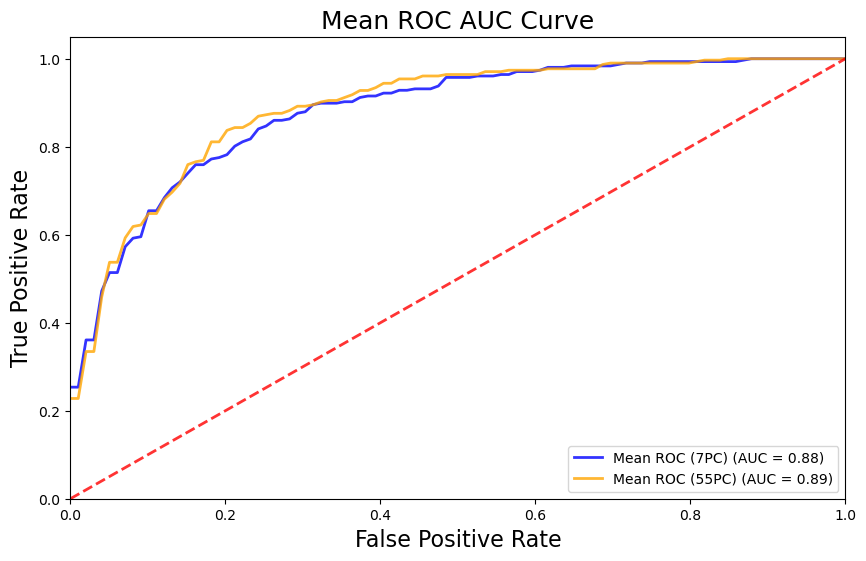

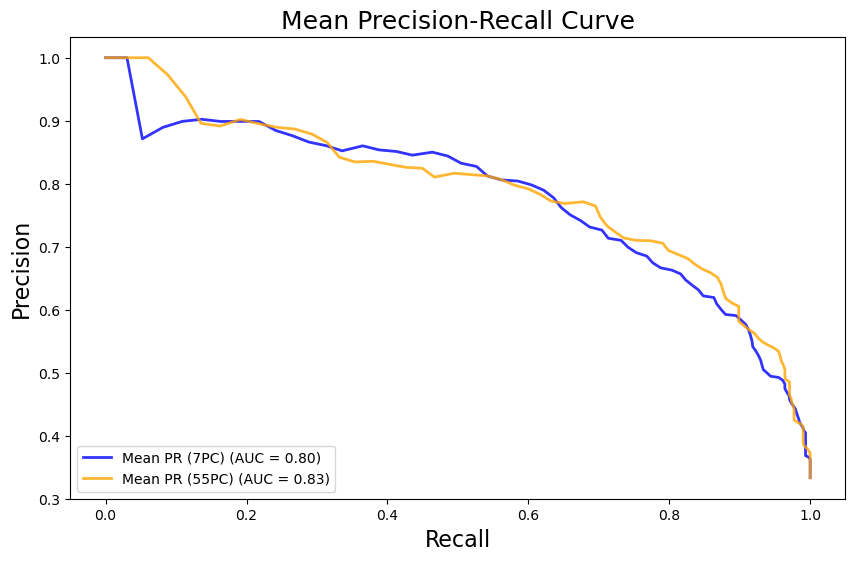

Final Training Set Class Distribution:
encoded_class
0    142
1    142
2     23
Name: count, dtype: int64


Exception ignored in: <function ResourceTracker.__del__ at 0x1067a5da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110f59da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10673dda0>
Traceback (most recent call last

In [7]:
#MULTICLASS CLASSIFICATION - 100PC

# Load your dataset
df = pd.read_csv("55_pc.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Impute missing values (debugging approach propsed by Gemini AI)
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

# copy df to avoid defragmentation
df = df.copy()

# Encode class labels
label_encoder = LabelEncoder()
df['encoded_class'] = label_encoder.fit_transform(df['flare_class_encoded'])

print("Encoded Class Distribution:")
print(df['encoded_class'].value_counts())

def create_multiclass_splits(df, n_repeats=100):
    all_splits = []
    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            c_class_samples = resample(df[df['encoded_class'] == 0], replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['encoded_class'] == 1], replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['encoded_class'] == 2], replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'encoded_class'])
            y = complete_data['encoded_class']  # Encoded multiclass target

            if len(X) == len(y):  # Ensure consistent lengths
                all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue
    return all_splits

# Function to evaluate model with GridSearchCV
def evaluate_model_with_xgboost(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'learning_rate': [0.1, 0.9],
        'subsample': [0.01, 1]
    }

    model_xgb = XGBClassifier(eval_metric='logloss')
    grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_xgb = grid_search.best_estimator_

        y_pred = best_model_xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_xgb.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), np.mean(f1_scores), accuracy_scores, roc_auc_scores, pr_auc_scores, f1_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multiclass classification with 10-fold cross-validation and GridSearchCV
multiclass_splits = create_multiclass_splits(df)
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    multiclass_results = [evaluate_model_with_xgboost(X, y) for X, y in multiclass_splits]
    mean_multiclass_accuracy = np.mean([result[0] for result in multiclass_results])
    mean_multiclass_roc_auc = np.mean([result[1] for result in multiclass_results])
    mean_multiclass_pr_auc_55PC = np.mean([result[2] for result in multiclass_results])
    mean_f1_score = np.mean([result[3] for result in multiclass_results])

    print(f"Mean Multiclass Accuracy: {mean_multiclass_accuracy}")
    print(f"Mean Multiclass ROC AUC: {mean_multiclass_roc_auc}")
    print(f"Mean Multiclass PR AUC: {mean_multiclass_pr_auc_55PC}")
    print(f"Mean Multiclass F1 Score: {mean_f1_score}")

     # combined Plot Mean ROC AUC Curve (8;100 PC)
    mean_fpr_55PC = np.linspace(0, 1, 100)
    tpr_interpolated_55PC = [np.interp(mean_fpr_55PC, fpr, tpr) for fpr, tpr in zip(multiclass_results[4][8], multiclass_results[4][9]) if isinstance(fpr, np.ndarray) and isinstance(tpr, np.ndarray)]
    mean_tpr_55PC = np.mean(tpr_interpolated_55PC, axis=0)
    mean_tpr_55PC[-1] = 1.0
    mean_roc_auc_55PC = auc(mean_fpr_55PC, mean_tpr_55PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_7PC, mean_tpr_7PC, color='blue', label=f'Mean ROC (7PC) (AUC = {mean_roc_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_55PC, mean_tpr_55PC, color='orange', label=f'Mean ROC (55PC) (AUC = {mean_roc_auc_55PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Mean ROC AUC Curve', fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC_AUC_curve_XGB_MULTICLASS.png")
    plt.show()

     # combined Plot Mean PR Curve (8;100 PC)
    precision_interpolated_55PC = [np.interp(mean_fpr_55PC, np.linspace(0, 1, len(precision)), precision) for precision in multiclass_results[4][10] if isinstance(precision, np.ndarray)]
    recall_interpolated_55PC = [np.interp(mean_fpr_55PC, np.linspace(0, 1, len(recall)), recall) for recall in multiclass_results[4][11] if isinstance(recall, np.ndarray)]
    mean_precision_55PC = np.mean(precision_interpolated_55PC, axis=0)
    mean_recall_55PC = np.mean(recall_interpolated_55PC, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_7PC, mean_precision_7PC, color='blue', label=f'Mean PR (7PC) (AUC = {mean_multiclass_pr_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_55PC, mean_precision_55PC, color='orange', label=f'Mean PR (55PC) (AUC = {mean_multiclass_pr_auc_55PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Mean Precision-Recall Curve', fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR_curve_XGB_MULTICLASS.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")
